In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from yellowbrick.text import PosTagVisualizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 

import sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from yellowbrick.classifier import confusion_matrix
import random
random.seed(123)

import eli5


In [97]:
df = pd.read_csv('fake_job_postings.csv')

# I. Overview

In [98]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


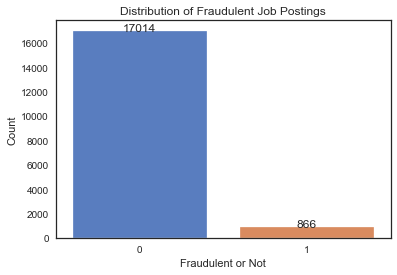

In [99]:
sns.set_style("ticks")
sns.set_palette("muted")
plt.figure(figsize = (6,4))
ax = sns.countplot(x = 'fraudulent', data = df)
total = float(len(df))
plt.title('Distribution of Fraudulent Job Postings')
plt.xlabel('Fraudulent or Not')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0}'.format(height),
            ha="center") 
plt.show()

Class distribution is highly imbalanced. Accuracy metric is not useful here because we want to focus on the 1's.  
So, we will use Precision, Recall, F1 Score for model evalution.

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [101]:
# Check Categories
for col in df.columns:
    print(f'Unique rows in {col}:', df[col].nunique())

Unique rows in job_id: 17880
Unique rows in title: 11231
Unique rows in location: 3105
Unique rows in department: 1337
Unique rows in salary_range: 874
Unique rows in company_profile: 1709
Unique rows in description: 14801
Unique rows in requirements: 11968
Unique rows in benefits: 6205
Unique rows in telecommuting: 2
Unique rows in has_company_logo: 2
Unique rows in has_questions: 2
Unique rows in employment_type: 5
Unique rows in required_experience: 7
Unique rows in required_education: 13
Unique rows in industry: 131
Unique rows in function: 37
Unique rows in fraudulent: 2


In [102]:
# Check Missing Values
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

# II. EDA
## A. Categorical Features

In [103]:
'''Extracting categorical features for EDA'''
df_category = df[['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 
                  'required_experience', 'required_education','fraudulent']]
df_category = df_category.fillna('NA')
df_category.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent
0,0,1,0,Other,Internship,NA,0
1,0,1,0,Full-time,Not Applicable,NA,0
2,0,1,0,NA,NA,NA,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,0


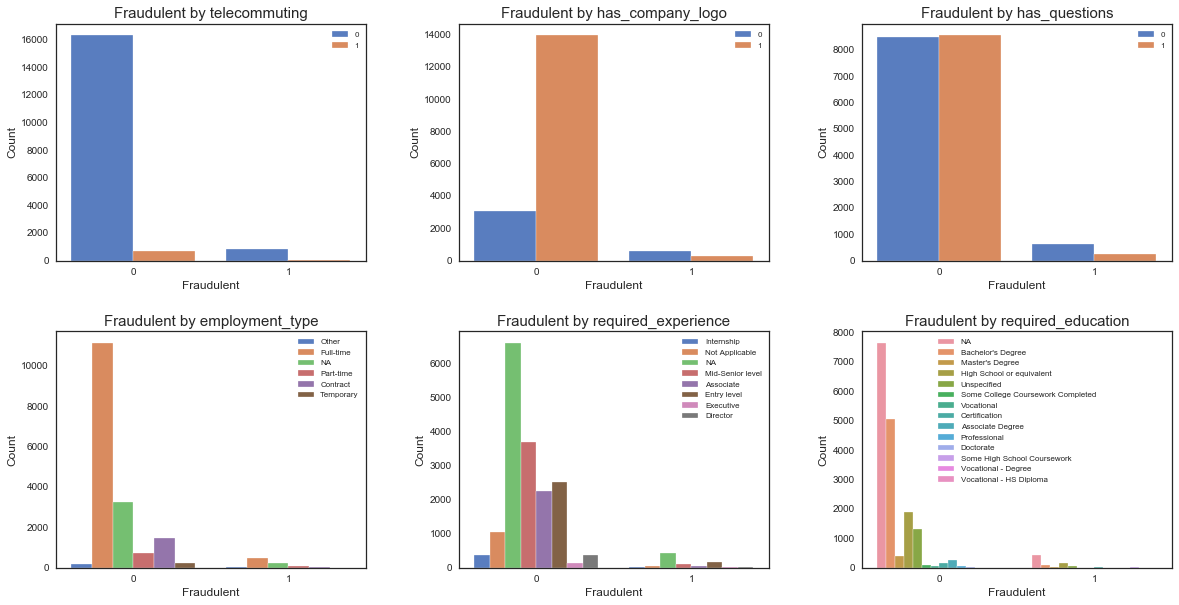

In [104]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", 
            "required_education"]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec 
grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.3) 
plt.figure(figsize=(20,10)) 

# loop to get column and the count of plots
for n, col in enumerate(df_category[cat_cols]): 
    ax = plt.subplot(grid[n])
    sns.countplot(x='fraudulent', data= df_category, hue=col) 
    ax.set_ylabel('Count', fontsize=12) 
    ax.set_title(f'Fraudulent by {col}', fontsize=15) 
    ax.set_xlabel(f'Fraudulent', fontsize=12) 
    plt.legend(fontsize=8)

plt.show()

## B. Text Overview

In [203]:
'''Extracting text features for classification'''
df_text = df[['title','location','department', 'company_profile', 'description', 'requirements', 'benefits',
              'employment_type','required_experience','required_education', 'industry', 'function', 'fraudulent']]
df_text = df_text.fillna(' ')
df_text.head()

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Other,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [205]:
cols = ['company_profile','description', 'requirements', 'benefits']

### 1. Number of Characters

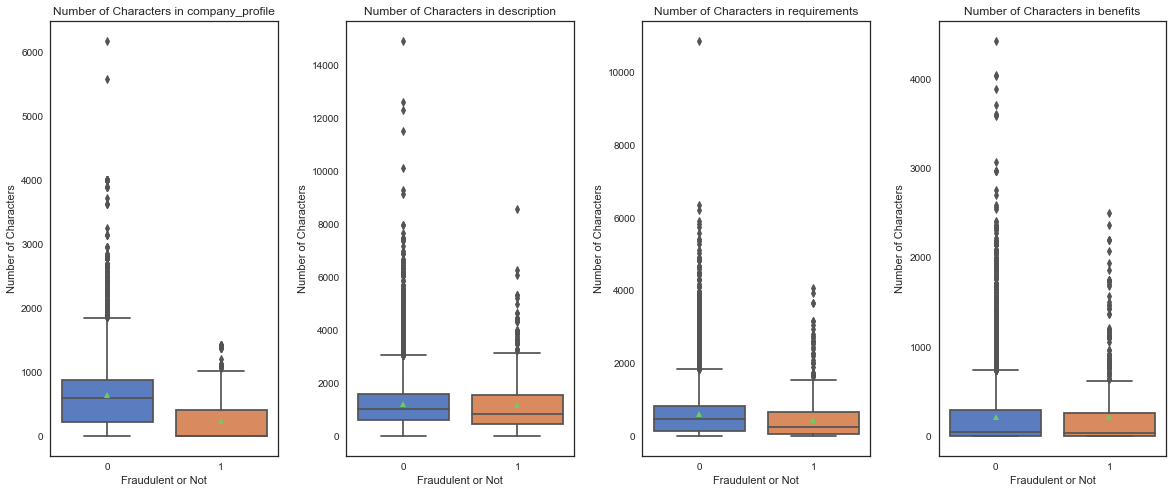

In [12]:
grid = gridspec.GridSpec(1, 4, wspace=0.3, hspace=0.3) 
plt.figure(figsize=(20,8))

for n, col in enumerate(df_text[cols]):
    axes = plt.gca()
    ax = plt.subplot(grid[n])
    sns.boxplot(x=df_text["fraudulent"], y=df_text[col].str.len(), showmeans = True)
    ax.set_title(f'Number of Characters in {col}')
    ax.set_xlabel('Fraudulent or Not')
    ax.set_ylabel('Number of Characters')
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels()

plt.show()


### 2. Number of Words

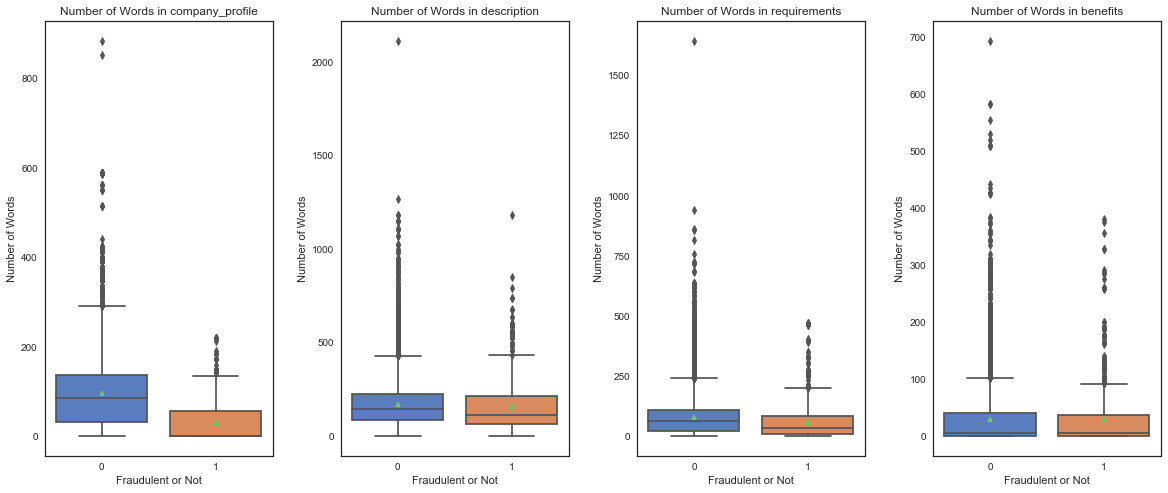

In [13]:
grid = gridspec.GridSpec(1, 4, wspace=0.3, hspace=0.3) 
plt.figure(figsize=(20,8))

for n, col in enumerate(df_text[cols]):
    axes = plt.gca()
    ax = plt.subplot(grid[n])
    sns.boxplot(x=df_text["fraudulent"], y=df_text[col].str.split().map(lambda x: len(x)), showmeans = True)
    ax.set_title(f'Number of Words in {col}')
    ax.set_xlabel('Fraudulent or Not')
    ax.set_ylabel('Number of Words')
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels()

plt.show()

# III. Text Mining

## A. Text Cleaning & Pre-Processing

In [224]:
df_text2 = df[['title','location','department', 'company_profile', 'description', 'requirements', 'benefits',
              'employment_type','required_education', 'industry', 'function', 'fraudulent']]
df_text2 = df_text2.fillna('Blank')
df_text2.head()

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Blank,Other,Blank,Blank,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Blank,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Blank,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Blank,Blank,Blank,Blank,Blank,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",Blank,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [230]:
'''Putting all text together'''
text = df_text2[df_text2.columns[0:-1]].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)
text = list(text)
print(len(text))
print(type(text))
label = df_text2['fraudulent']
print(len(label))

17880
<class 'list'>
17880


In [227]:
'''Cleaning the text'''
stop_words = stopwords.words('english')
stop_words = set(stop_words)

def clean_text(text:list)->list:
    cleaned_post_lst = [] # Return a list of cleaned version of job post
    for post in text:
        post = post.lower() # Lowercase
        post = re.sub(r'http(s?)://\S+|www\.\S+|#url_\S+', '', post) # Remove links and URLs
        post = re.sub(r'[^\w\s]', '', post) # Remove special characters and punctuations
        word_lst = []
        for word in post.split(' '):
            if word != '':
                if word not in stop_words:
                    word_lst.append(word)
        cleaned_post_lst.append(' '.join(word_lst))
    return cleaned_post_lst 

# Clean all text
all_clean = clean_text(text)

In [228]:
'''Create the cleaned dataset for modeling'''
dataset = pd.DataFrame({'post':all_clean, 'label': label})
dataset.head()
#dataset.to_csv (r'clean_job.csv', index = False, header=True)

,post,label
0,marketing intern us ny new york marketing food...,0
1,customer service cloud video production nz auc...,0
2,commissioning machinery assistant cma us ia we...,0
3,account executive washington dc us dc washingt...,0
4,bill review manager us fl fort worth blank spo...,0


## B. Generating WordCloud

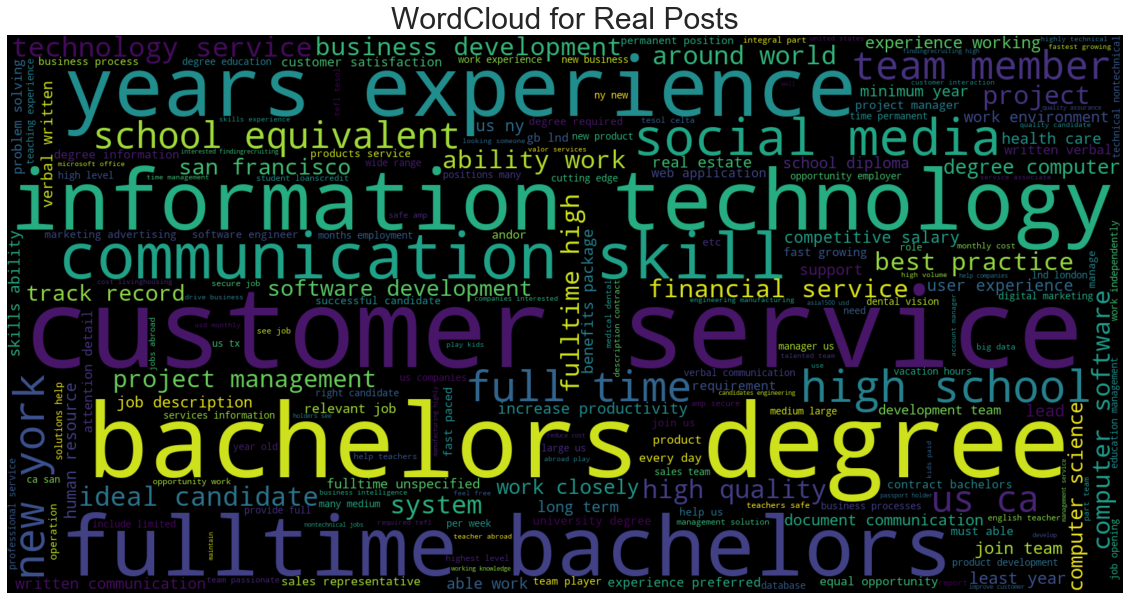

In [257]:
'''WordCloud image for Real Posts'''
stopwords = set(STOPWORDS)
stopwords.update(["blank"])

wordcloud = WordCloud(width = 1600, height = 800, stopwords = stopwords,
                      collocations=True).generate(" ".join(dataset[dataset.label == 0].post))

# Display the generated image:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Real Posts', fontsize = 30)
plt.show()

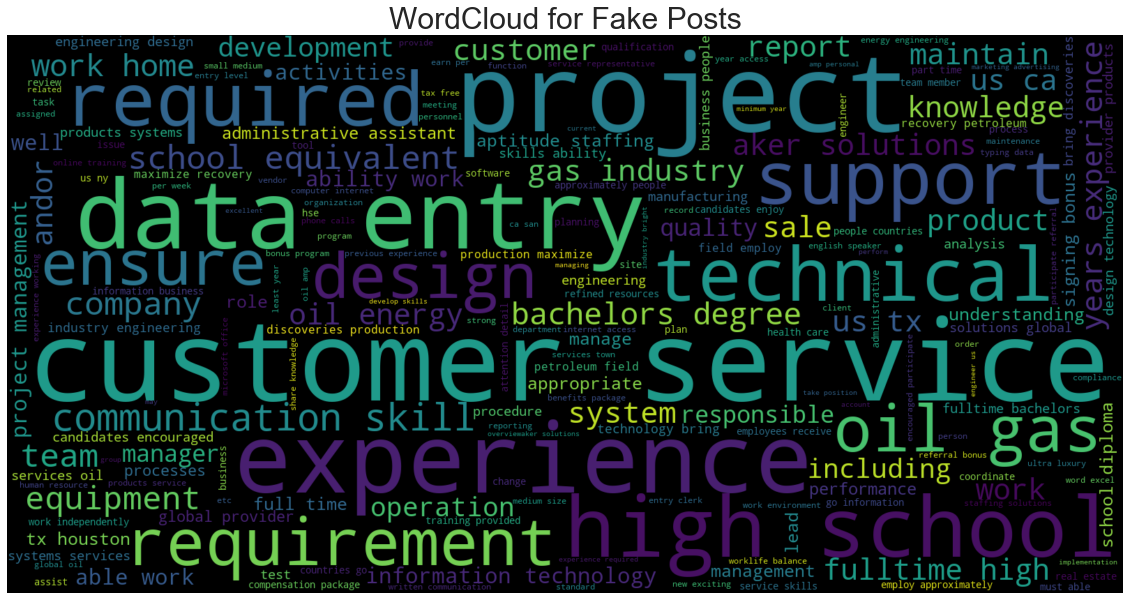

In [258]:
'''WordCloud image for Fake Posts'''
wordcloud = WordCloud(width = 1600, height = 800, stopwords = stopwords,
                      collocations=True).generate(" ".join(dataset[dataset.label == 1].post))

# Display the generated image:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Fake Posts', fontsize = 30)
plt.show()

## C. Top Unigrams & Bigrams

In [265]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words = stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Text(0.5, 1.0, 'Top 20 Unigrams for Fake Posts')

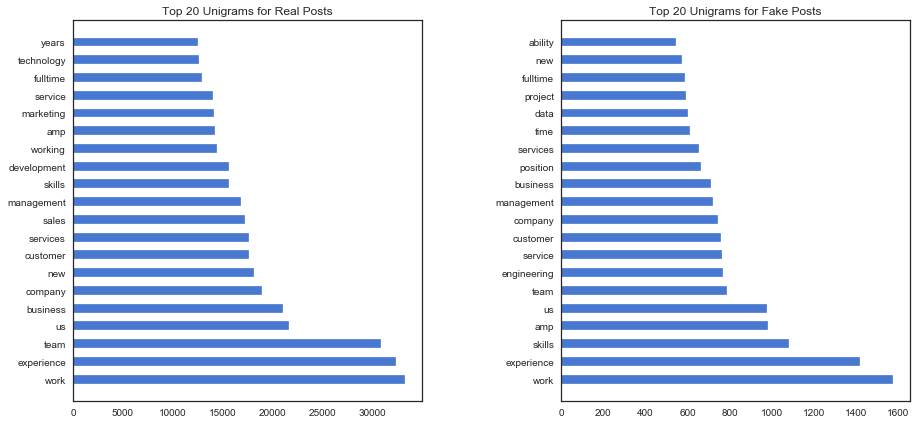

In [266]:
'''Top Unigrams'''
top_words_real = get_top_n_words(dataset[dataset.label == 0].post, 20)
df_real_count = pd.DataFrame(top_words_real, columns = ['Words' , 'Count'])

top_words_fake = get_top_n_words(dataset[dataset.label == 1].post, 20)
df_fake_count = pd.DataFrame(top_words_fake, columns = ['Words' , 'Count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
plt.subplots_adjust(wspace = 0.4)
ax1.barh(df_real_count.Words, df_real_count.Count, height = 0.5)
ax1.set_title('Top 20 Unigrams for Real Posts')
ax2.barh(df_fake_count.Words, df_fake_count.Count, height = 0.5)
ax2.set_title('Top 20 Unigrams for Fake Posts')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Text(0.5, 1.0, 'Top 20 Bigrams for Fake Posts')

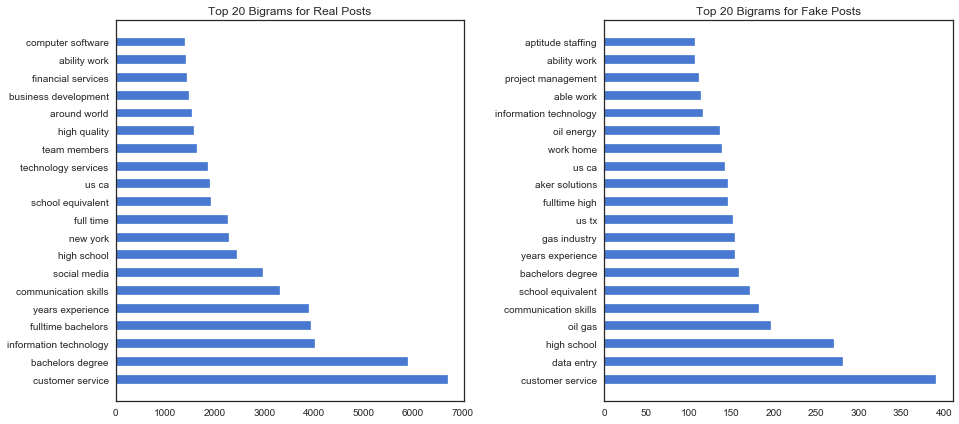

In [267]:
'''Top Bigrams'''
top_bigram_real = get_top_n_bigram(dataset[dataset.label == 0].post, 20)
df_real_bigram = pd.DataFrame(top_bigram_real, columns = ['Bigrams' , 'Count'])

top_bigram_fake = get_top_n_bigram(dataset[dataset.label == 1].post, 20)
df_fake_bigram = pd.DataFrame(top_bigram_fake, columns = ['Bigrams' , 'Count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
plt.subplots_adjust(wspace = 0.4)
ax1.barh(df_real_bigram.Bigrams, df_real_bigram.Count, height = 0.5)
ax1.set_title('Top 20 Bigrams for Real Posts')
ax2.barh(df_fake_bigram.Bigrams, df_fake_bigram.Count, height = 0.5)
ax2.set_title('Top 20 Bigrams for Fake Posts')

# IV. Modeling

In [236]:
'''Splitting Dataset'''
class Dataset:
  def __init__(self, dataset, start_idx, end_idx):
    self.post = dataset.post[start_idx:end_idx]
    self.label = dataset.label[start_idx:end_idx]
    self.vecs = None
    
def split_dataset(dataset, train_rate=0.75):
  data_size = len(dataset.post)
  train_last_idx = int(train_rate * data_size)
  train = Dataset(dataset, 0, train_last_idx)
  test = Dataset(dataset, train_last_idx, data_size)
  return train, test

train, test = split_dataset(dataset)
print('train data size:', len(train.post))
print('test data size:', len(test.post))

train data size: 13410
test data size: 4470


In [237]:
'''Some Utilities Functions'''

def classification(vectorizer, model, print_cm=False): # Printing out evaluation metrics
  train.vecs = vectorizer.transform(train.post)
  test.vecs = vectorizer.transform(test.post)
  model.fit(train.vecs, train.label)
  train_preds = model.predict(train.vecs)
  test_preds = model.predict(test.vecs)
  
  # Evaluation metrics
  train_f1 = f1_score(train.label, train_preds, average='micro')
  test_f1 = f1_score(test.label, test_preds, average='micro')
  test_recall = recall_score(test.label, test_preds, average='micro')
  print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)

  # Print out Confusion Matrix
  if print_cm:
        confusion_matrix(model, train.vecs, train.label, test.vecs, test.label)
  
  return

def get_result(vectorizer, model): # Creating a dataframe with label and prediction of the test set
  train.vecs = vectorizer.transform(train.post)
  test.vecs = vectorizer.transform(test.post)
  model.fit(train.vecs, train.label)
  train_preds = model.predict(train.vecs)
  test_preds = model.predict(test.vecs)
  test_result = pd.DataFrame({'post':test.post, 'label': test.label, 'pred': test_preds})
  
  return test_result

def get_error(result): # Print out False Negatives
    FN = []
    for i in range(0,4470):
        if result.pred.iloc[i] == 0 and result.label.iloc[i] == 1:
            FN.append(result.post.iloc[i])
    return FN

def plot(cs, train_f1_list, test_f1_list): # Generating F1 Score Graph for Grid Search
    plt.clf()
    plt.plot(cs, train_f1_list, label='Train F1')
    plt.plot(cs, test_f1_list, label='Test F1')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

## A. Count Vectorizer

In [238]:
# Count Vectorizer
cv_vectorizer = CountVectorizer(ngram_range=(1,3), min_df = 2, max_df = 10000) 
train.vecs = cv_vectorizer.fit_transform(train.post)
test.vecs = cv_vectorizer.transform(test.post)

Train F1: 1.0 , Test F1: 0.9648769574944072 , Test Recall: 0.9648769574944072
Train F1: 1.0 , Test F1: 0.9648769574944072 , Test Recall: 0.9648769574944072
Train F1: 1.0 , Test F1: 0.9646532438478748 , Test Recall: 0.9646532438478748
Train F1: 1.0 , Test F1: 0.9648769574944072 , Test Recall: 0.9648769574944072
Train F1: 1.0 , Test F1: 0.9651006711409396 , Test Recall: 0.9651006711409396
Train F1: 1.0 , Test F1: 0.9651006711409396 , Test Recall: 0.9651006711409396
Train F1: 1.0 , Test F1: 0.9653243847874721 , Test Recall: 0.9653243847874721
Train F1: 1.0 , Test F1: 0.9651006711409396 , Test Recall: 0.9651006711409396
Train F1: 1.0 , Test F1: 0.9653243847874721 , Test Recall: 0.9653243847874721
Train F1: 1.0 , Test F1: 0.9657718120805369 , Test Recall: 0.9657718120805369
Train F1: 1.0 , Test F1: 0.9657718120805369 , Test Recall: 0.9657718120805369
Train F1: 1.0 , Test F1: 0.9659955257270694 , Test Recall: 0.9659955257270694
Train F1: 1.0 , Test F1: 0.9659955257270694 , Test Recall: 0.965

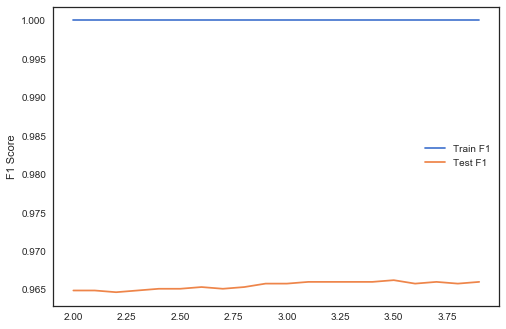

In [239]:
'''Logistic Regression'''
cs = np.arange(2, 4, 0.1)
train_f1_list = list()
test_f1_list = list()

for c in cs:
    model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = c) # Best F1 0.9662: C = 3.5
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list)   

Train F1: 0.9988814317673378 , Test F1: 0.9615212527964205 , Test Recall: 0.9615212527964205
Train F1: 0.9986577181208054 , Test F1: 0.961744966442953 , Test Recall: 0.961744966442953
Train F1: 0.9985085756897838 , Test F1: 0.962192393736018 , Test Recall: 0.962192393736018
Train F1: 0.9980611483967189 , Test F1: 0.9626398210290827 , Test Recall: 0.9626398210290827
Train F1: 0.9978374347501864 , Test F1: 0.9635346756152126 , Test Recall: 0.9635346756152126
Train F1: 0.9976882923191648 , Test F1: 0.963758389261745 , Test Recall: 0.963758389261745
Train F1: 0.9974645786726324 , Test F1: 0.9644295302013423 , Test Recall: 0.9644295302013423
Train F1: 0.9972408650260999 , Test F1: 0.9646532438478748 , Test Recall: 0.9646532438478748
Train F1: 0.9970171513795675 , Test F1: 0.9646532438478748 , Test Recall: 0.9646532438478748


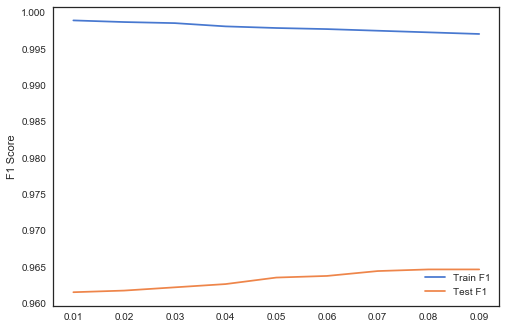

In [242]:
'''Multinomial Naive Bayes'''
cs = np.arange(0.01, 0.1, 0.01)
train_f1_list = list()
test_f1_list = list()

for a in cs:
    model = MultinomialNB(alpha = a) # Best F1 0.9647: alpha = 0.08
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)
    
plot(cs, train_f1_list, test_f1_list)  

In [245]:
'''Random Forest'''
cs = np.arange(100, 300, 50)
cs2 = np.arange(0.01, 0.03, 0.005)
train_f1_list = list()
test_f1_list = list()

for n in cs:
    for s in cs2: # Best F1 0.9503
        model = RandomForestClassifier(n_estimators = n, criterion="entropy", min_samples_split=s)
        model.fit(train.vecs, train.label)
        train_preds = model.predict(train.vecs)
        test_preds = model.predict(test.vecs)
        (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
        print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
        train_f1_list.append(train_score)
        test_f1_list.append(test_score)

Train F1: 0.9933631618195377 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392
Train F1: 0.9929157345264727 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392
Train F1: 0.9932140193885161 , Test F1: 0.9503355704697987 , Test Recall: 0.9503355704697987
Train F1: 0.9932885906040269 , Test F1: 0.9483221476510068 , Test Recall: 0.9483221476510068
Train F1: 0.9932140193885161 , Test F1: 0.9487695749440715 , Test Recall: 0.9487695749440715
Train F1: 0.9929903057419835 , Test F1: 0.9483221476510068 , Test Recall: 0.9483221476510068
Train F1: 0.9929157345264727 , Test F1: 0.9487695749440715 , Test Recall: 0.9487695749440715
Train F1: 0.9930648769574945 , Test F1: 0.9478747203579418 , Test Recall: 0.9478747203579418
Train F1: 0.9934377330350485 , Test F1: 0.9489932885906041 , Test Recall: 0.9489932885906041
Train F1: 0.9931394481730053 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392
Train F1: 0.9932885906040269 , Test F1: 0.9489932885906041 , Test Reca

Train F1: 0.9999254287844892 , Test F1: 0.962192393736018 , Test Recall: 0.962192393736018
Train F1: 1.0 , Test F1: 0.9619686800894854 , Test Recall: 0.9619686800894854
Train F1: 1.0 , Test F1: 0.9628635346756153 , Test Recall: 0.9628635346756153
Train F1: 1.0 , Test F1: 0.9626398210290827 , Test Recall: 0.9626398210290827


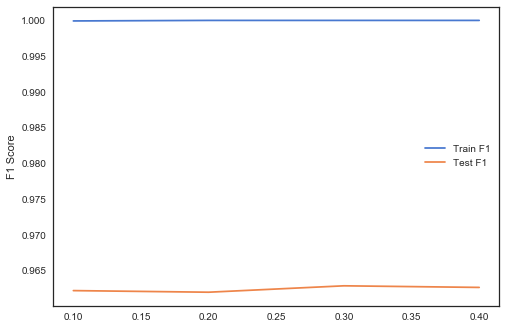

In [248]:
'''Support Vector Machine'''
cs = np.arange(0.1, 0.5, 0.1)
train_f1_list = list()
test_f1_list = list()

for c in cs:
    model = SVC(C = c, kernel = 'linear') # Best F1 0.9629: C = 0.3
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)
    
plot(cs, train_f1_list, test_f1_list) 

Train F1: 0.991200596569724 , Test F1: 0.9384787472035794 , Test Recall: 0.9384787472035794
Train F1: 0.9849366144668158 , Test F1: 0.9058165548098434 , Test Recall: 0.9058165548098434
Train F1: 0.990007457121551 , Test F1: 0.9496644295302014 , Test Recall: 0.9496644295302014
Train F1: 0.9906040268456375 , Test F1: 0.9492170022371365 , Test Recall: 0.9492170022371365
Train F1: 0.9870991797166294 , Test F1: 0.9476510067114094 , Test Recall: 0.9476510067114094
Train F1: 0.9885160328113348 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392
Train F1: 0.9840417598806861 , Test F1: 0.9436241610738255 , Test Recall: 0.9436241610738255
Train F1: 0.984862043251305 , Test F1: 0.9458612975391499 , Test Recall: 0.9458612975391499


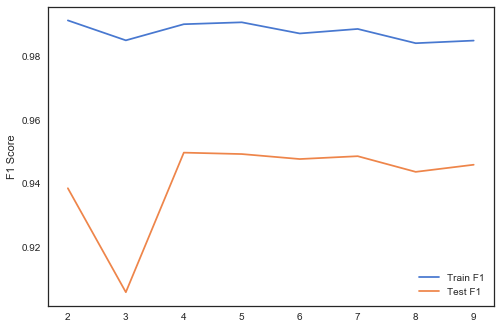

In [250]:
'''K-Nearest Neighbors'''
cs = np.arange(2, 10, 1)
train_f1_list = list()
test_f1_list = list()

for c in cs:
    model = KNeighborsClassifier(n_neighbors = c, p = 2, metric = 'minkowski') # Best F1 0.9629: n = 4
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)
    
plot(cs, train_f1_list, test_f1_list) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


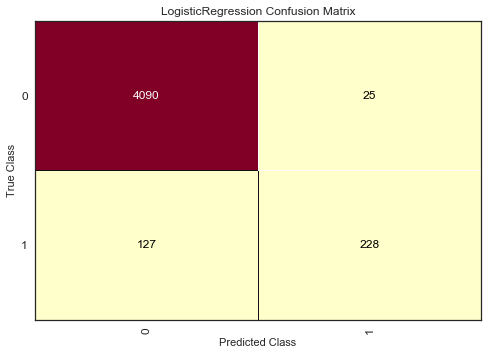

(1.0, 0.9659955257270694, 0.9659955257270694, 0.9659955257270694)


In [286]:
'''Best Model Parameters'''
LR = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 3.5) # 0.9662
NB = MultinomialNB(alpha = 0.08) # 0.9647
RF = RandomForestClassifier(n_estimators = 100, criterion="entropy", min_samples_split=0.02) # 0.9503
SV = SVC(C = 0.3, kernel = 'linear') # 0.9629
KN = KNeighborsClassifier(n_neighbors = 3, p = 2, metric = 'minkowski') # 0.9497

print(classification(cv_vectorizer, LR, print_cm = True))
# print(classification(cv_vectorizer, NB))
# print(classification(cv_vectorizer, RF))
# print(classification(cv_vectorizer, SV))
# print(classification(cv_vectorizer, KN))

In [253]:
'''Feature Importance - Logistic Regression'''
pipe = make_pipeline(cv_vectorizer, LR)
pipe.fit(train.post, train.label)
eli5.show_weights(pipe, target_names=test.label, top = 40)

Weight?,Feature
+8.646,using link
+6.285,rohan
+5.130,aptitude staffing
+4.435,line requirements1
+3.446,wages
+3.005,accion
+2.840,gary
+2.398,home based
+2.358,difficult
+2.229,general finance


In [287]:
'''Feature Importance - Random Forest'''
pipe = make_pipeline(cv_vectorizer, RF)
pipe.fit(train.post, train.label)
eli5.show_weights(pipe, target_names=test.label, top = 40)

Weight,Feature
0.0035 ± 0.0310,goals makeing
0.0032 ± 0.0288,leveraging career
0.0027 ± 0.0261,valueswe looking
0.0024 ± 0.0136,blank blank
0.0022 ± 0.0160,blank apply
0.0021 ± 0.0243,oil gas
0.0021 ± 0.0159,apply using link
0.0020 ± 0.0225,career new exciting
0.0020 ± 0.0164,blank apply using
0.0019 ± 0.0240,friendly colleagues industry


## B. Tfidf Vectorizer

In [254]:
# Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df = 2, max_df = 10000)
train.vecs = tfidf_vectorizer.fit_transform(train.post)
test.vecs = tfidf_vectorizer.transform(test.post)

Train F1: 0.9997017151379568 , Test F1: 0.9680089485458613 , Test Recall: 0.9680089485458613
Train F1: 0.9998508575689784 , Test F1: 0.9675615212527964 , Test Recall: 0.9675615212527964
Train F1: 0.9998508575689784 , Test F1: 0.967337807606264 , Test Recall: 0.967337807606264
Train F1: 0.9998508575689784 , Test F1: 0.967337807606264 , Test Recall: 0.967337807606264
Train F1: 0.9998508575689784 , Test F1: 0.9675615212527964 , Test Recall: 0.9675615212527964
Train F1: 0.9998508575689784 , Test F1: 0.967337807606264 , Test Recall: 0.967337807606264
Train F1: 0.9998508575689784 , Test F1: 0.967337807606264 , Test Recall: 0.967337807606264
Train F1: 0.9998508575689784 , Test F1: 0.967337807606264 , Test Recall: 0.967337807606264
Train F1: 0.9998508575689784 , Test F1: 0.9675615212527964 , Test Recall: 0.9675615212527964
Train F1: 0.9998508575689784 , Test F1: 0.9675615212527964 , Test Recall: 0.9675615212527964


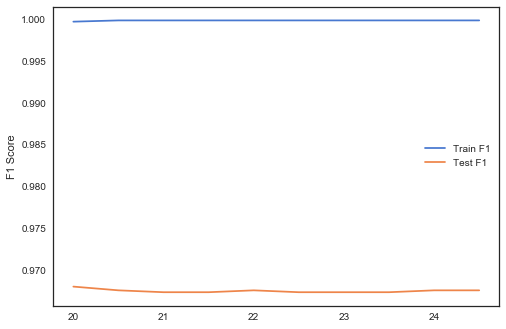

In [273]:
'''Logistic Regression'''
cs = np.arange(20, 25, 0.5)
train_f1_list = list()
test_f1_list = list()

for c in cs:
    model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = c) # Best F1 0.9680: C = 20
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)
    
plot(cs, train_f1_list, test_f1_list) 

Train F1: 0.9967934377330351 , Test F1: 0.9601789709172259 , Test Recall: 0.9601789709172259
Train F1: 0.9889634601043997 , Test F1: 0.9548098434004474 , Test Recall: 0.9548098434004474
Train F1: 0.9857568978374347 , Test F1: 0.9527964205816555 , Test Recall: 0.9527964205816555
Train F1: 0.9838180462341536 , Test F1: 0.9498881431767338 , Test Recall: 0.9498881431767338
Train F1: 0.9825503355704698 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392
Train F1: 0.9826994780014914 , Test F1: 0.9480984340044742 , Test Recall: 0.9480984340044742
Train F1: 0.9834451901565996 , Test F1: 0.9476510067114094 , Test Recall: 0.9476510067114094
Train F1: 0.9849366144668158 , Test F1: 0.9474272930648769 , Test Recall: 0.9474272930648769
Train F1: 0.9857568978374347 , Test F1: 0.9478747203579418 , Test Recall: 0.9478747203579418


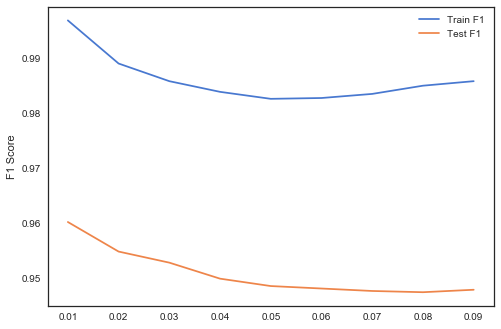

In [274]:
'''Multinomial Naive Bayes'''
cs = np.arange(0.01, 0.1, 0.01)
train_f1_list = list()
test_f1_list = list()

for a in cs:
    model = MultinomialNB(alpha = a) # Best F1 0.9602: alpha = 0.01
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list)

In [275]:
'''Random Forest'''
cs = np.arange(100, 300, 50)
cs2 = np.arange(0.01, 0.03, 0.005)
train_f1_list = list()
test_f1_list = list()

for n in cs:
    for s in cs2: # Best F1 0.9492
        model = RandomForestClassifier(n_estimators = n, criterion="entropy", min_samples_split=s)
        model.fit(train.vecs, train.label)
        train_preds = model.predict(train.vecs)
        test_preds = model.predict(test.vecs)
        (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
        print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
        train_f1_list.append(train_score)
        test_f1_list.append(test_score)

Train F1: 0.994034302759135 , Test F1: 0.9489932885906041 , Test Recall: 0.9489932885906041
Train F1: 0.9932140193885161 , Test F1: 0.9492170022371365 , Test Recall: 0.9492170022371365
Train F1: 0.9932885906040269 , Test F1: 0.9483221476510068 , Test Recall: 0.9483221476510068
Train F1: 0.9930648769574945 , Test F1: 0.9480984340044742 , Test Recall: 0.9480984340044742
Train F1: 0.99358687546607 , Test F1: 0.9489932885906041 , Test Recall: 0.9489932885906041
Train F1: 0.9932140193885161 , Test F1: 0.9480984340044742 , Test Recall: 0.9480984340044742
Train F1: 0.9931394481730053 , Test F1: 0.9480984340044742 , Test Recall: 0.9480984340044742
Train F1: 0.9929903057419835 , Test F1: 0.9474272930648769 , Test Recall: 0.9474272930648769
Train F1: 0.9934377330350485 , Test F1: 0.9480984340044742 , Test Recall: 0.9480984340044742
Train F1: 0.9934377330350485 , Test F1: 0.9478747203579418 , Test Recall: 0.9478747203579418
Train F1: 0.992841163310962 , Test F1: 0.9478747203579418 , Test Recall: 

Train F1: 0.9903803131991051 , Test F1: 0.9492170022371365 , Test Recall: 0.9492170022371365
Train F1: 0.9969425801640567 , Test F1: 0.9552572706935123 , Test Recall: 0.9552572706935123
Train F1: 0.9994780014914243 , Test F1: 0.9601789709172259 , Test Recall: 0.9601789709172259
Train F1: 0.9997762863534676 , Test F1: 0.961744966442953 , Test Recall: 0.961744966442953
Train F1: 0.9997762863534676 , Test F1: 0.9619686800894854 , Test Recall: 0.9619686800894854


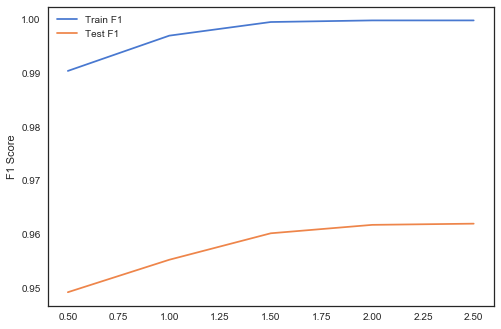

In [282]:
'''Support Vector Machine'''
cs = np.arange(0.5, 3, 0.5)
train_f1_list = list()
test_f1_list = list()

for c in cs:
    model = SVC(C = c, kernel = 'linear') # Best F1 0.9620: C = 3
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list) 

Train F1: 0.9951528709917972 , Test F1: 0.9628635346756153 , Test Recall: 0.9628635346756153
Train F1: 0.9917225950782997 , Test F1: 0.9646532438478748 , Test Recall: 0.9646532438478748
Train F1: 0.9929903057419835 , Test F1: 0.9615212527964205 , Test Recall: 0.9615212527964205
Train F1: 0.9923191648023862 , Test F1: 0.9644295302013423 , Test Recall: 0.9644295302013423
Train F1: 0.9913497390007457 , Test F1: 0.9592841163310962 , Test Recall: 0.9592841163310962
Train F1: 0.9914988814317673 , Test F1: 0.962192393736018 , Test Recall: 0.962192393736018
Train F1: 0.9903803131991051 , Test F1: 0.9557046979865772 , Test Recall: 0.9557046979865772
Train F1: 0.9905294556301267 , Test F1: 0.9577181208053691 , Test Recall: 0.9577181208053691


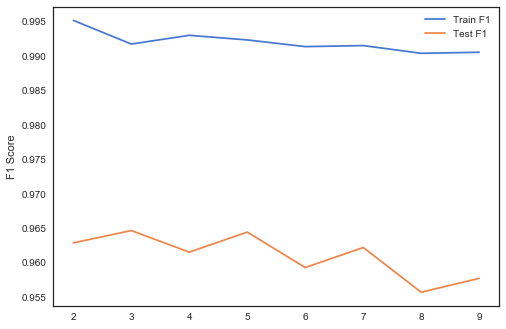

In [276]:
'''K-Nearest Neighbors'''
cs = np.arange(2, 10, 1)
train_f1_list = list()
test_f1_list = list()

for c in cs: 
    model = KNeighborsClassifier(n_neighbors = c, p = 2, metric = 'minkowski') # Best F1 0.9647: n = 3
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


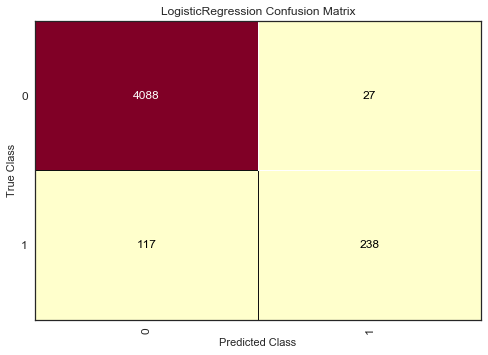

(0.9997017151379568, 0.9677852348993289, 0.9677852348993289, 0.9677852348993289)


In [288]:
'''Best Model Parameters'''
LR = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 20) # 0.9680
NB = MultinomialNB(alpha = 0.01) # 0.9602
RF = RandomForestClassifier(n_estimators = 100, criterion="entropy", min_samples_split=0.015) # 0.9492
SV = SVC(C = 3, kernel = 'linear') # 0.9620
KN = KNeighborsClassifier(n_neighbors = 3, p = 2, metric = 'minkowski') # 0.9647

print(classification(tfidf_vectorizer, LR, print_cm = True)) 
# print(classification(tfidf_vectorizer, NB)) 
# print(classification(tfidf_vectorizer, RF)) 
# print(classification(tfidf_vectorizer, SV))
# print(classification(tfidf_vectorizer, KN))

In [285]:
'''Feature Importance - Logistic Regression'''
pipe = make_pipeline(tfidf_vectorizer, LR)
pipe.fit(train.post, train.label)
eli5.show_weights(pipe, target_names=test.label, top = 40)

Weight?,Feature
+182.989,aptitude staffing
+114.240,refined resources
+112.609,using link
+91.775,line requirements1
+74.253,aker
+60.997,mortgage protection
+58.352,wages
+52.079,work time sensitive
+50.250,payroll data
+49.088,novation


In [289]:
'''Feature Importance - Random Forest'''
pipe = make_pipeline(tfidf_vectorizer, RF)
pipe.fit(train.post, train.label)
eli5.show_weights(pipe, target_names=test.label, top = 40)

Weight,Feature
0.0030 ± 0.0329,design technology bring
0.0025 ± 0.0284,benefits strong
0.0023 ± 0.0253,provider products systems
0.0023 ± 0.0189,using link
0.0022 ± 0.0269,information business people
0.0022 ± 0.0144,blank blank
0.0021 ± 0.0241,amp personal
0.0021 ± 0.0168,apply using link
0.0020 ± 0.0200,solutions redesigned recruiting
0.0020 ± 0.0272,petroleum field


## C. Feature Union with Custom Features

In [290]:
'''Creating Custom Features'''
def spelling_error(post):
    target_word = ['makeing', 'fiit', 'overviewaker', 'recruitng']
    count = 0
    for word in post.split(' '):
        if word in target_word:
            count += 1      
    return count

def num_of_words(post):
    length = 0
    for word in post.split(' '):
        length += 1    
    return length

def fake_unigram(post):
    target_word = ['wages', 'accion', 'rohan', 'gary', 'novation', 'difficult', 'qatar', 'tester', 'clearmark']
    count = 0
    for word in post.split(' '):
        if word in target_word:
            count += 1      
    return count

def fake_bigram(post):
    text_lst = []
    bigrams = ngrams(post.split(), 2)
    target_phrase = ['apply using', 'using link', 'aptitude staffing', 'work home', 'home based', 'refined resources',
                     'oil energy', 'data entry', 'line requirements1', 'general finance', 'candidates encouraged',
                     'aker solutions', 'makeing solid', 'events contract', 'high school', 'technical project',
                    'payroll data']
    count = 0
    for bigram in bigrams:
        text_lst.append(bigram[0] + " " + bigram[1])
    for bigram in text_lst:
        if bigram in target_phrase:
            count += 1
    return count  

def blank_count(post):
    target_word = ['blank']
    count = 0
    for word in post.split(' '):
        if word in target_word:
            count += 1      
    return count

In [291]:
class CustomFeats(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.feat_names = set()

    def fit(self, x, y=None):
        return self

    @staticmethod
    def features(post):
        return {
          'spelling error' : spelling_error(post),
          'length': num_of_words(post),
          'fake unigram': fake_unigram(post),  
          'fake bigram': fake_bigram(post),
          'blank': blank_count(post)

      }

    def get_feature_names(self):
        return list(self.feat_names)
      
    def transform(self, posts):
      feats = []
      for post in posts:
        f = self.features(post)
        [self.feat_names.add(k) for k in f] 
        feats.append(f)
      return feats

In [307]:
'''Feature Union'''
big_vectorizer = FeatureUnion([
    ('custom', make_pipeline(CustomFeats(), DictVectorizer())),
    ('bag_of_words', CountVectorizer(ngram_range=(1,3), min_df = 2, max_df = 10000)),
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df = 2, max_df = 10000))
])

train.vecs = big_vectorizer.fit(train.post)
train.vecs = big_vectorizer.transform(train.post)
test.vecs = big_vectorizer.transform(test.post)

Train F1: 1.0 , Test F1: 0.9639821029082773 , Test Recall: 0.9639821029082773
Train F1: 1.0 , Test F1: 0.9644295302013423 , Test Recall: 0.9644295302013423
Train F1: 1.0 , Test F1: 0.9635346756152126 , Test Recall: 0.9635346756152126
Train F1: 1.0 , Test F1: 0.96331096196868 , Test Recall: 0.96331096196868
Train F1: 1.0 , Test F1: 0.9635346756152126 , Test Recall: 0.9635346756152126
Train F1: 1.0 , Test F1: 0.9648769574944072 , Test Recall: 0.9648769574944072
Train F1: 1.0 , Test F1: 0.9653243847874721 , Test Recall: 0.9653243847874721
Train F1: 1.0 , Test F1: 0.9635346756152126 , Test Recall: 0.9635346756152126
Train F1: 1.0 , Test F1: 0.9648769574944072 , Test Recall: 0.9648769574944072
Train F1: 1.0 , Test F1: 0.9639821029082773 , Test Recall: 0.9639821029082773


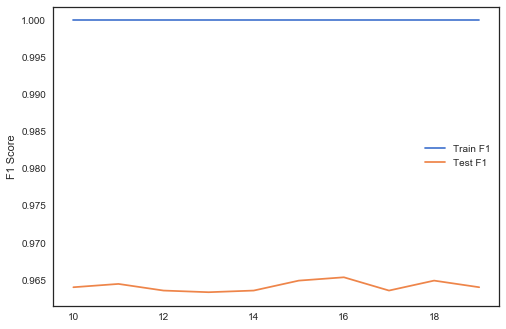

In [308]:
'''Logistic Regression'''
cs = np.arange(10, 20, 1)
train_f1_list = list()
test_f1_list = list()

for c in cs:
    model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = c) # Best F1 0.9649: C = 15
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list)

Train F1: 0.9989560029828486 , Test F1: 0.9619686800894854 , Test Recall: 0.9619686800894854
Train F1: 0.9987322893363162 , Test F1: 0.961744966442953 , Test Recall: 0.961744966442953
Train F1: 0.9986577181208054 , Test F1: 0.961744966442953 , Test Recall: 0.961744966442953
Train F1: 0.9985085756897838 , Test F1: 0.9619686800894854 , Test Recall: 0.9619686800894854
Train F1: 0.9985085756897838 , Test F1: 0.9619686800894854 , Test Recall: 0.9619686800894854
Train F1: 0.9985085756897838 , Test F1: 0.9615212527964205 , Test Recall: 0.9615212527964205
Train F1: 0.9985085756897838 , Test F1: 0.9610738255033557 , Test Recall: 0.9610738255033557
Train F1: 0.9983594332587621 , Test F1: 0.9608501118568232 , Test Recall: 0.9608501118568232
Train F1: 0.9982848620432513 , Test F1: 0.9610738255033557 , Test Recall: 0.9610738255033557


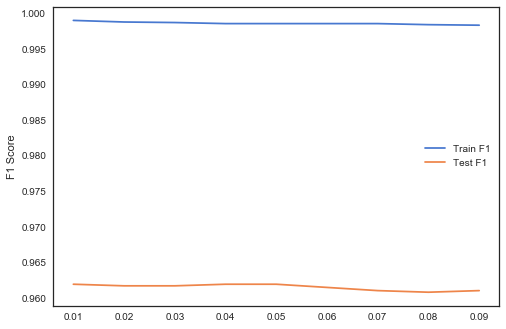

In [309]:
'''Multinomial Naive Bayes'''
cs = np.arange(0.01, 0.1, 0.01)
train_f1_list = list()
test_f1_list = list()

for a in cs:
    model = MultinomialNB(alpha = a) # Best F1 0.9620: alpha = 0.01
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list)

In [310]:
'''Random Forest'''
cs = np.arange(100, 300, 50)
cs2 = np.arange(0.01, 0.03, 0.01)
train_f1_list = list()
test_f1_list = list()

for n in cs:
    for s in cs2: # Best F1 0.9497
        model = RandomForestClassifier(n_estimators = n, criterion="entropy", min_samples_split=s)
        model.fit(train.vecs, train.label)
        train_preds = model.predict(train.vecs)
        test_preds = model.predict(test.vecs)
        (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
        print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
        train_f1_list.append(train_score)
        test_f1_list.append(test_score)

Train F1: 0.9938851603281134 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392
Train F1: 0.9934377330350485 , Test F1: 0.9496644295302014 , Test Recall: 0.9496644295302014
Train F1: 0.9939597315436242 , Test F1: 0.9492170022371365 , Test Recall: 0.9492170022371365
Train F1: 0.9935123042505593 , Test F1: 0.9496644295302014 , Test Recall: 0.9496644295302014
Train F1: 0.9938851603281134 , Test F1: 0.9489932885906041 , Test Recall: 0.9489932885906041
Train F1: 0.9932885906040269 , Test F1: 0.9483221476510068 , Test Recall: 0.9483221476510068
Train F1: 0.9937360178970918 , Test F1: 0.9487695749440715 , Test Recall: 0.9487695749440715
Train F1: 0.9935123042505593 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392


Train F1: 1.0 , Test F1: 0.9628635346756153 , Test Recall: 0.9628635346756153
Train F1: 1.0 , Test F1: 0.9628635346756153 , Test Recall: 0.9628635346756153
Train F1: 1.0 , Test F1: 0.9628635346756153 , Test Recall: 0.9628635346756153
Train F1: 1.0 , Test F1: 0.9628635346756153 , Test Recall: 0.9628635346756153
Train F1: 1.0 , Test F1: 0.9628635346756153 , Test Recall: 0.9628635346756153


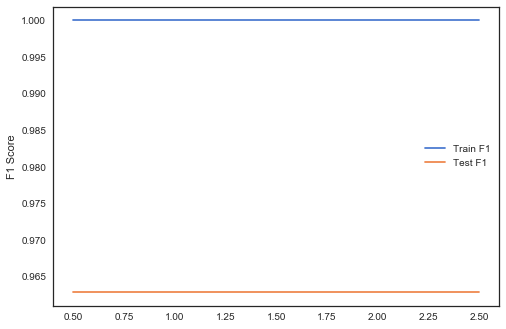

In [311]:
'''Support Vector Machine'''
cs = np.arange(0.5, 3, 0.5)
train_f1_list = list()
test_f1_list = list()

for c in cs:
    model = SVC(C = c, kernel = 'linear') # Best F1 0.9629: C = 1
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list)

Train F1: 0.9873228933631618 , Test F1: 0.9494407158836689 , Test Recall: 0.9494407158836689
Train F1: 0.9879194630872483 , Test F1: 0.951006711409396 , Test Recall: 0.951006711409396
Train F1: 0.9818046234153617 , Test F1: 0.9476510067114094 , Test Recall: 0.9476510067114094
Train F1: 0.9822520507084266 , Test F1: 0.9485458612975392 , Test Recall: 0.9485458612975392
Train F1: 0.9778523489932885 , Test F1: 0.938255033557047 , Test Recall: 0.938255033557047
Train F1: 0.978448918717375 , Test F1: 0.9393736017897092 , Test Recall: 0.9393736017897092
Train F1: 0.9744220730797912 , Test F1: 0.9362416107382551 , Test Recall: 0.9362416107382551
Train F1: 0.9749440715883669 , Test F1: 0.9362416107382551 , Test Recall: 0.9362416107382551


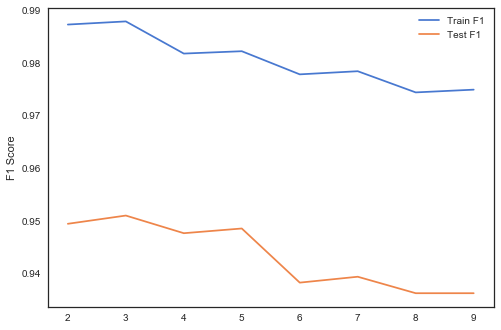

In [312]:
'''K-Nearest Neighbors'''
cs = np.arange(2, 10, 1)
train_f1_list = list()
test_f1_list = list()

for c in cs: 
    model = KNeighborsClassifier(n_neighbors = c, p = 2, metric = 'minkowski') # Best F1 0.9510: n = 3
    model.fit(train.vecs, train.label)
    train_preds = model.predict(train.vecs)
    test_preds = model.predict(test.vecs)
    (train_score, test_score, test_recall) = (f1_score(train.label, train_preds, average='micro'), 
                                              f1_score(test.label, test_preds, average='micro'),
                                             recall_score(test.label, test_preds, average='micro'))
    print("Train F1:", train_score, ", Test F1:", test_score, ", Test Recall:",test_recall)
    train_f1_list.append(train_score)
    test_f1_list.append(test_score)

plot(cs, train_f1_list, test_f1_list)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


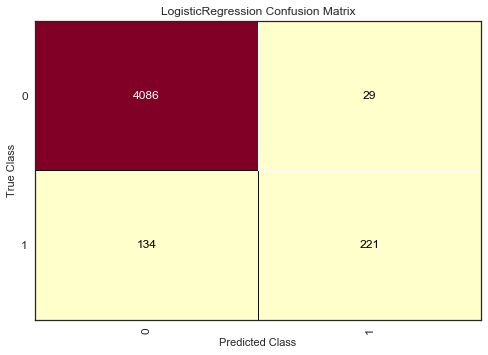

(1.0, 0.9635346756152126, 0.9635346756152126, 0.9635346756152126)


In [313]:
'''Best Model Parameters'''
LR = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 15) # 0.9649
NB = MultinomialNB(alpha = 0.01) # 0.9620
RF = RandomForestClassifier(n_estimators = 100, criterion="entropy", min_samples_split=0.02) # 0.9497
SV = SVC(C = 1, kernel = 'linear') # 0.9629
KN = KNeighborsClassifier(n_neighbors = 3, p = 2, metric = 'minkowski') # 0.9510

print(classification(big_vectorizer, LR, print_cm = True)) 
# print(classification(big_vectorizer, NB))
# print(classification(big_vectorizer, RF))
# print(classification(big_vectorizer, SV))
# print(classification(big_vectorizer, KN))

In [315]:
'''Feature Importance - Logistic Regression'''
pipe = make_pipeline(big_vectorizer, LR)
pipe.fit(train.post, train.label)
eli5.show_weights(pipe, target_names=test.label, top = 40)

Weight?,Feature
+6.401,bag_of_words:using link
+5.669,custom:fake unigram
+4.160,custom:fake bigram
+3.629,bag_of_words:line requirements1
+3.556,bag_of_words:rohan
+3.293,bag_of_words:agent us
+2.543,bag_of_words:entered
+2.453,bag_of_words:aptitude
+2.449,bag_of_words:1000
+2.419,bag_of_words:sydney blank blank


In [316]:
'''Feature Importance - Random Forest'''
pipe = make_pipeline(big_vectorizer, RF)
pipe.fit(train.post, train.label)
eli5.show_weights(pipe, target_names=test.label, top = 40)

Weight,Feature
0.0042 ± 0.0541,custom:fake bigram
0.0027 ± 0.0315,bag_of_words:technology bring discoveries
0.0026 ± 0.0190,bag_of_words:blank apply
0.0025 ± 0.0251,tfidf:candidates enjoy following
0.0024 ± 0.0275,tfidf:process provide
0.0020 ± 0.0162,bag_of_words:blank apply using
0.0020 ± 0.0144,bag_of_words:blank blank
0.0019 ± 0.0273,bag_of_words:oil gas industry
0.0018 ± 0.0211,tfidf:recruitng model
0.0017 ± 0.0257,bag_of_words:aptitude staffing


## V. Best Model

In [318]:
'''Best Model Error Analysis'''
best_model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 20)
best_result = get_result(tfidf_vectorizer, best_model)
error = get_error(best_result)

In [319]:
error[0]

'vessel coordinator us tx houston blank blank listing infoorganize expro international shipping vessel operations export facilities us gulf make effective decisions operating vessels port coordinate daily activities nova boarding agents ensure vessels operated effective timely costefficient mannerresponsibilities organize vessel operations vessel owner operator terminals provide proactive timely communication vessel owners operators terminals caterers ships crew government entities make effective decisions best manage vessels port reduce risk cost time port ensure federal state local government regulations requirements met coordinate vessel attendance nova boarding agents ensure efficient vessel operations ensure arrangements vessel operations organized proactively timely including pilots tugs launches hold cleaning services cash master ensure vessel documentation meets government requirements cargill accounting standards maintain strong working relationships provide best class service

In [320]:
error[1]

'northwestern hospital blank blank blank build website blank blank blank blank blank blank'

In [321]:
error[2]

'test automation engineer us oh groveport blank blank position\xa0 test automation engineerlocation groveport ohduration\xa0 6 months contract hire\xa0skills\xa0javahtmlcucumberrubyseleniumelectric commanderjenkins\xa0\xa0responsibilities write test scenarios using test frameworks cucumber languages java rubyproduce wellwritten efficient highquality selfdocumenting test code follows best practices design patternsdesign implement launch highlyvisible features retail platform using testbehavior driven development practicesuse critical thinking skills exploratory testingcontinuously grow skills value paired programming code reviewspractice relentless automation continuous integration continuous delivery continuous improvementrecommend adopt new technologies well keeping existing technologies leading edge versionsinterface project team develop test strategy featurereport quality project department leadershipbe ambassador open source community share passion testing innovation learn testing 